In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from PIL import Image, UnidentifiedImageError
import os
from torch.utils.data import Dataset, DataLoader
import requests
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from tqdm.notebook import tqdm_notebook as tqdm
from io import BytesIO
import re

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df_train = pd.read_csv('/kaggle/input/ai-of-god-3/Public_data/train.csv')

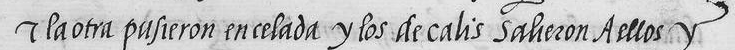

In [4]:
li=[]
# a = set()
img_path = '/kaggle/input/ai-of-god-3/Public_data/train_images'
ids = list(df_train['unique Id'].astype(str))
for item in os.listdir(img_path):
    po=[]
    full_path = os.path.join(img_path,item)
    if(full_path.endswith('.png')):
        po.append(full_path)
        s = str(item)
        s = s[:-4]
        # a.add(s)
        idx = ids.index(s)
        label = df_train.iloc[idx]['transcription']
        # for j in label:
        #     a.add(j)
#         img = Image.open(full_path)
#         img = np.array(img,dtype=np.float32)/255
#         if(img.shape[2]!=3):
#             continue
# #         augmented = train_transform(image=img)
# #         img = augmented['image']
        po.append(label)
        li.append(po)
Image.open(li[0][0])

In [5]:
df_tr = pd.DataFrame(li)

In [6]:
df_tr.rename(columns={0: 'image_path', 1: 'text'}, inplace=True)

In [7]:
df_tr.head()

,image_path,text
0,/kaggle/input/ai-of-god-3/Public_data/train_im...,& la otra pusieron en celada y los de calis sa...
1,/kaggle/input/ai-of-god-3/Public_data/train_im...,la muerte del Emperador_
2,/kaggle/input/ai-of-god-3/Public_data/train_im...,tam solamente el fuego non lo tanxo nin fizo E...
3,/kaggle/input/ai-of-god-3/Public_data/train_im...,llado y lleuolo el emperador fasta en santiago...
4,/kaggle/input/ai-of-god-3/Public_data/train_im...,"zimos que fue quinto fijo, se entiende contand..."


In [8]:
df_tr.to_csv('data_for_fine_tune.csv', index = False)

In [9]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

processor = TrOCRProcessor.from_pretrained('qantev/trocr-large-spanish')
model = VisionEncoderDecoderModel.from_pretrained('qantev/trocr-large-spanish')

preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.97k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


generation_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [17]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

In [12]:
!pip install peft

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 6.4 MB/s eta 0:00:0000:01


In [18]:
from peft import LoftQConfig, LoraConfig, get_peft_model

# base_model = AutoModelForCausalLM.from_pretrained(...)  # don't quantize here
loftq_config = LoftQConfig(loftq_bits=4)           # set 4bit quantization
# LoRA Configuration for OCR
lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=['q_proj', 'v_proj', 'k_proj', 'out_proj'],  # Common attention-related modules in transformer models
    lora_dropout=0.1,  # Dropout rate
    bias="none",  # Options: "none", "all", or "lora_only"
    task_type="SEQ2SEQ_LM"  # OCR task often treated as sequence-to-sequence language modeling
)

# Use this configuration when loading your model with LoRA

peft_model = get_peft_model(model, lora_config)

In [16]:
def con(img, threshold_value = 160):
    binary_img = img.point(lambda p: 255 if p > threshold_value else 0)

    # Convert binary image to RGB (optional)
    rgb_img = binary_img.convert('RGB')
    
    return rgb_img

In [15]:
df = pd.read_csv('/kaggle/working/data_for_fine_tune.csv')

In [21]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, dff, processor, max_target_length=128):
        self.df = dff
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
#         file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.df['image_path'][idx]).convert('L')
        image = con(image)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [22]:
train_dataset = IAMDataset(dff=df,
                           processor=processor)

In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [28]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

In [29]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
     

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(peft_model.parameters(), lr=5e-5)

for epoch in range(5):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

  0%|          | 0/939 [00:00<?, ?it/s]

In [19]:
# Save the fine-tuned model
model.save_pretrained("my_finetuned_model")

# Save the processor
processor.save_pretrained("my_finetuned_model")


[]

In [ ]:
# Zip the directory to make it easier to download or upload
!zip -r my_finetuned_model.zip my_finetuned_model/

In [ ]:
# # Unzip the model
# !unzip -q /kaggle/input/my_finetuned_model.zip -d /kaggle/working/

# # Load the fine-tuned model and processor
# from transformers import VisionEncoderDecoderModel, TrOCRProcessor

# # Load the model
# model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/my_finetuned_model")

# # Load the processor
# processor = TrOCRProcessor.from_pretrained("/kaggle/working/my_finetuned_model")
